In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.ndimage import binary_closing, binary_opening
from matplotlib.colors import LinearSegmentedColormap
from scipy.interpolate import interp1d



In [22]:
def conv(signal, kernel):
    signal_length = len(signal)
    kernel_length = len(kernel)
    output_length = signal_length - kernel_length + 1
    result = np.zeros(output_length)

    for i in range(output_length):
        signal_slice = signal[i:i + kernel_length]
        norm_signal_slice = signal_slice / np.linalg.norm(signal_slice)
        norm_kernel = kernel / np.linalg.norm(signal_slice)
        
        result[i] = np.dot(norm_signal_slice, norm_kernel)
        
    return result

In [23]:
def amplitude_in_band(conv_res, min_fr, max_fr):
    frequencies, times, Zxx = signal.stft(
        conv_res,
        fs=64,
        window='hann',
        nperseg=256,
        noverlap=250
    )

    freq_mask = (frequencies >= min_fr) & (frequencies <= max_fr)

    amplitude_in_band = np.mean(np.abs(Zxx[freq_mask, :]), axis=0)

    return amplitude_in_band


In [24]:
def create_mask(min_amplitude, amplitude_in_band, len_ppg):
    time_mask = amplitude_in_band > min_amplitude

    kernel = np.ones(10)
    time_mask = binary_closing(time_mask, kernel)
    time_mask_clean = binary_opening(time_mask, kernel)

    indices_mask = np.arange(len(time_mask_clean))
    indices_ppg = np.linspace(0, len(time_mask_clean) - 1, len_ppg)

    mask_func = interp1d(
        indices_mask,
        time_mask_clean,
        kind='nearest',
        bounds_error=False,
        fill_value=False
    )

    full_mask = mask_func(indices_ppg).astype(bool)


In [25]:
data = pd.read_pickle(f'/home/ilya/Documents/stress-level-by-PPG/data.pkl')
reference_wave = np.squeeze(np.load('./reference_wave.npy'))

# for number, person_data in data.items():

ppg = data['S2']['PPG_stress']


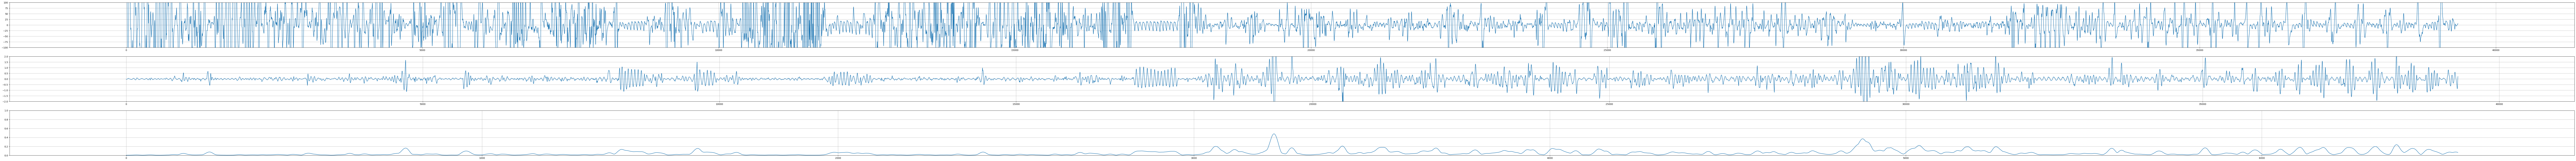

In [27]:
conv_res = conv(ppg, reference_wave)
res_amplitude = amplitude_in_band(conv_res, 0.7, 3)

plt.figure(figsize=(200, 12))

plt.subplot(3, 1, 1)
plt.plot(ppg)
plt.ylim(-100, 100)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(conv_res)
plt.ylim(-2, 2)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(res_amplitude)
plt.ylim(0, 1)
plt.grid(True)

plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/gavno.png', dpi=300, bbox_inches='tight')
# plt.show()

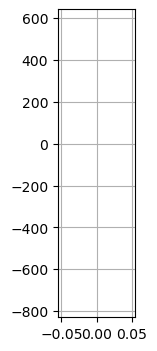

In [ ]:

conv_res = conv(ppg, reference_wave)
res_amplitude = amplitude_in_band(conv_res, 0.7, 3)
mask = create_mask(0.10, res_amplitude, len(ppg))


filt_ppg = ppg[mask]
plt.figure(figsize=(len(filt_ppg), 4))
plt.plot(filt_ppg)
plt.grid(True)
plt.savefig(f'./gavno.png', dpi=300, bbox_inches='tight')


array([241.76, 265.23, 289.46, ...,   5.24,   6.39,   7.27],
      shape=(39360,))

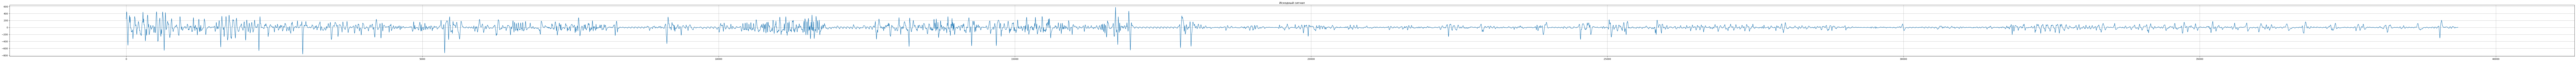

In [ ]:
plt.figure(figsize=(200, 4))
plt.plot(data["S2"]["PPG_stress"])
plt.title("Исходный сигнал")
plt.grid(True)

data["S2"]["PPG_stress"]